# Библиотеки

In [28]:
import os
import torch
import torchvision
from torchvision.datasets import EMNIST
from torchvision import transforms
from torchvision.transforms import ToTensor, Compose, Resize, Normalize
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from PIL import Image

import torchvision.transforms.functional as TF
import cv2
import optuna
from torchinfo import summary

# Получение, трансформация, нормализация и контроль данных

In [2]:
# Определение трансформаций для нормализации данных
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # Нормализация по среднему и стандартному отклонению
])

# Загрузка обучающего набора данных с трансформациями
train_data = EMNIST('data_r/', 'balanced', train=True, download=True,
                transform=torchvision.transforms.Compose([ # Поворот и отражение
                    lambda img: torchvision.transforms.functional.rotate(img, -90),
                    lambda img: torchvision.transforms.functional.hflip(img),
                    transform # трансформируем и нормализуем
                ]))

# Загрузка тестового набора данных с трансформациями
test_data = EMNIST('data_r/', 'balanced', train=False,
                transform=torchvision.transforms.Compose([ # Поворот и отражение
                    lambda img: torchvision.transforms.functional.rotate(img, -90),
                    lambda img: torchvision.transforms.functional.hflip(img),
                    transform # трансформируем и нормализуем
                ]))

In [3]:
# получение маппинга
with open('emnist-balanced-mapping.txt', 'r') as f:
    mapping = f.readlines()

#mapping

In [4]:
# Создаем словарь соответствий
label_dict = {}
for entry in mapping:
    label, ascii_code = map(int, entry.split())
    label_dict[label] = chr(ascii_code)

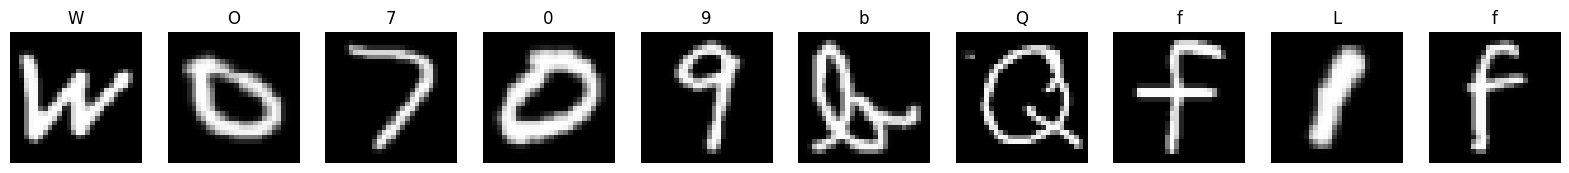

In [5]:
# Проверяем корректность изображений
fig, axs = plt.subplots(1, 10, figsize=(20, 5))
for i in range(10):
    random_index = np.random.randint(0, len(train_data))
    #print('Random index:', random_index)
    image, label = train_data[random_index]

    # Преобразование изображения в NumPy массив для корректного отображения
    image_np = image.numpy()  # Прямое преобразование в NumPy массив

    # Убираем размерность канала (если она есть)
    if image_np.shape[0] == 1:  # Если канал один (черно-белое изображение)
        image_np = image_np.squeeze(0)  # Убираем размерность канала

    # Отображаем изображение
    axs[i].imshow(image_np, cmap='gray')
    axs[i].set_title(label_dict[label])  # Используем словарь для отображения метки
    axs[i].axis('off')

plt.show()


In [5]:
# Создание загрузчиков данных
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [34]:
# простая модель
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # Свертка с 32 фильтрами
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # Свертка с 64 фильтрами
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Подвыборка
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Полносвязный слой
        self.fc2 = nn.Linear(128, 47)  # Выходной слой для 47 классов

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Применение свертки и активации ReLU
        x = self.pool(F.relu(self.conv2(x)))  # Применение свертки и активации ReLU
        x = x.view(-1, 64 * 7 * 7)  # Преобразование в вектор для полносвязного слоя
        x = F.relu(self.fc1(x))  
        x = self.fc2(x)  
        return x

In [15]:
# Очищаем состояние для последующей модели
def clear_training_state(model, optimizer):
    # Удаляем все параметры и градиенты
    model.apply(lambda m: m.reset_parameters() if hasattr(m, 'reset_parameters') else None)
    optimizer.state.clear()  # Очищаем состояние оптимизатора
    optimizer.param_groups.clear()  # Очищаем группы параметров

In [9]:
# Используем функцию для очистки состояния
#clear_training_state(model, optimizer)

# Инициализация модели
model_cnn = CNNModel()

# Оптимизатор и функция потерь
optimizer = optim.Adam(model_cnn.parameters(), lr=0.001)  # Используем Adam с малой скоростью обучения
loss_function = nn.CrossEntropyLoss()  # Функция потерь для многоклассовой классификации

In [10]:
n_epochs = 10

for epoch in range(n_epochs):
    model_cnn.train()  # Устанавливаем режим обучения
    running_loss = 0.0

    for data, target in train_loader:
        optimizer.zero_grad()  # Обнуляем градиенты
        output = model_cnn(data)  # Прямой проход через модель
        loss = loss_function(output, target)  # Вычисление потерь
        loss.backward()  # Обратный проход (вычисление градиентов)
        optimizer.step()  # Обновление параметров

        running_loss += loss.item()

    print(f'Epoch {epoch + 1}/{n_epochs}, Loss: {running_loss / len(train_loader):.4f}')

    # Валидация модели после каждой эпохи
    model_cnn.eval()
    correct = 0

    with torch.no_grad():
        for data, target in val_loader:
            output = model_cnn(data)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()

    accuracy = correct / len(val_loader.dataset)
    print(f'Validation Accuracy: {accuracy:.4f}')

Epoch 1/10, Loss: 0.6189
Validation Accuracy: 0.8539
Epoch 2/10, Loss: 0.3756
Validation Accuracy: 0.8636
Epoch 3/10, Loss: 0.3220
Validation Accuracy: 0.8746
Epoch 4/10, Loss: 0.2852
Validation Accuracy: 0.8727
Epoch 5/10, Loss: 0.2575
Validation Accuracy: 0.8735
Epoch 6/10, Loss: 0.2307
Validation Accuracy: 0.8680
Epoch 7/10, Loss: 0.2096
Validation Accuracy: 0.8702
Epoch 8/10, Loss: 0.1900
Validation Accuracy: 0.8722
Epoch 9/10, Loss: 0.1739
Validation Accuracy: 0.8701
Epoch 10/10, Loss: 0.1584
Validation Accuracy: 0.8637


In [11]:
# Сохранение модели в формате .ckpt
torch.save(model_cnn.state_dict(), 'model_r_1.ckpt')

In [35]:
# Загрузка предварительно обученной модели
model = CNNModel()  # модель уже определена
model.load_state_dict(torch.load('model_r_1.ckpt'))

# Вывод информации о модели
summary(model, input_size=(1, 1, 28, 28))  # Указываем размер входного тензора [batch_size, channels, height, width]

/tmp/ipykernel_6454/1872050039.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_r_1.ckpt'))


Layer (type:depth-idx)                   Output Shape              Param #
CNNModel                                 [1, 47]                   --
├─Conv2d: 1-1                            [1, 32, 28, 28]           320
├─MaxPool2d: 1-2                         [1, 32, 14, 14]           --
├─Conv2d: 1-3                            [1, 64, 14, 14]           18,496
├─MaxPool2d: 1-4                         [1, 64, 7, 7]             --
├─Linear: 1-5                            [1, 128]                  401,536
├─Linear: 1-6                            [1, 47]                   6,063
Total params: 426,415
Trainable params: 426,415
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 4.28
Input size (MB): 0.00
Forward/backward pass size (MB): 0.30
Params size (MB): 1.71
Estimated Total Size (MB): 2.01

In [32]:
#упрощенная модель

class SimplifiedCNNModel(nn.Module):
    def __init__(self):
        super(SimplifiedCNNModel, self).__init__()
        # Первый свертка + активация + подвыборка
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)  # Уменьшено до 16 фильтров
        self.bn1 = nn.BatchNorm2d(16)  # Нормализация
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Подвыборка
        
        # Второй свертка + активация + подвыборка
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # Уменьшено до 32 фильтров
        self.bn2 = nn.BatchNorm2d(32)  # Нормализация
        
        # Полносвязные слои
        self.fc1 = nn.Linear(32 * 7 * 7, 128)  # Измените размер в зависимости от входного размера
        self.fc2 = nn.Linear(128, 47)  # Выходной слой для 47 классов
        self.dropout = nn.Dropout(0.5)  # Дропаут для регуляризации

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # Свертка 1
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # Свертка 2
        x = x.view(-1, 32 * 7 * 7)  # Преобразование в вектор для полносвязного слоя
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Применение дропаута
        x = self.fc2(x)
        return x

In [13]:
# Используем функцию для очистки состояния
clear_training_state(model_cnn, optimizer)

# Инициализация модели
model_cnn_2 = SimplifiedCNNModel()

# Оптимизатор и функция потерь
optimizer = optim.Adam(model_cnn_2.parameters(), lr=0.001)  # Используем Adam с малой скоростью обучения
loss_function = nn.CrossEntropyLoss()  # Функция потерь для многоклассовой классификации

In [14]:
# Создание загрузчиков данных
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [15]:
n_epochs = 10

for epoch in range(n_epochs):
    model_cnn_2.train()  # Устанавливаем режим обучения
    running_loss = 0.0

    for data, target in train_loader:
        optimizer.zero_grad()  # Обнуляем градиенты
        output = model_cnn_2(data)  # Прямой проход через модель
        loss = loss_function(output, target)  # Вычисление потерь
        loss.backward()  # Обратный проход (вычисление градиентов)
        optimizer.step()  # Обновление параметров

        running_loss += loss.item()

    print(f'Epoch {epoch + 1}/{n_epochs}, Loss: {running_loss / len(train_loader):.4f}')

    # Валидация модели после каждой эпохи
    model_cnn_2.eval()
    correct = 0

    with torch.no_grad():
        for data, target in val_loader:
            output = model_cnn_2(data)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()

    accuracy = correct / len(val_loader.dataset)
    print(f'Validation Accuracy: {accuracy:.4f}')


Epoch 1/10, Loss: 1.3163
Validation Accuracy: 0.8071
Epoch 2/10, Loss: 0.9039
Validation Accuracy: 0.8338
Epoch 3/10, Loss: 0.8214
Validation Accuracy: 0.8366
Epoch 4/10, Loss: 0.7704
Validation Accuracy: 0.8461
Epoch 5/10, Loss: 0.7257
Validation Accuracy: 0.8533
Epoch 6/10, Loss: 0.6876
Validation Accuracy: 0.8545
Epoch 7/10, Loss: 0.6575
Validation Accuracy: 0.8560
Epoch 8/10, Loss: 0.6405
Validation Accuracy: 0.8606
Epoch 9/10, Loss: 0.6181
Validation Accuracy: 0.8632
Epoch 10/10, Loss: 0.6052
Validation Accuracy: 0.8627


In [16]:
# Сохранение модели в формате .ckpt
torch.save(model_cnn_2.state_dict(), 'model_r_2.ckpt')

In [33]:
# Загрузка предварительно обученной модели
model = SimplifiedCNNModel()  # модель уже определена
model.load_state_dict(torch.load('model_r_2.ckpt'))

# Вывод информации о модели
summary(model, input_size=(1, 1, 28, 28))  # Указываем размер входного тензора [batch_size, channels, height, width]

/tmp/ipykernel_6454/1951370409.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_r_2.ckpt'))


Layer (type:depth-idx)                   Output Shape              Param #
SimplifiedCNNModel                       [1, 47]                   --
├─Conv2d: 1-1                            [1, 16, 28, 28]           160
├─BatchNorm2d: 1-2                       [1, 16, 28, 28]           32
├─MaxPool2d: 1-3                         [1, 16, 14, 14]           --
├─Conv2d: 1-4                            [1, 32, 14, 14]           4,640
├─BatchNorm2d: 1-5                       [1, 32, 14, 14]           64
├─MaxPool2d: 1-6                         [1, 32, 7, 7]             --
├─Linear: 1-7                            [1, 128]                  200,832
├─Dropout: 1-8                           [1, 128]                  --
├─Linear: 1-9                            [1, 47]                   6,063
Total params: 211,791
Trainable params: 211,791
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 1.24
Input size (MB): 0.00
Forward/backward pass size (MB): 0.30
Params size (MB): 0.85
Estimated Total Si

In [30]:
class BigCNNModel(nn.Module):
    def __init__(self):
        super(BigCNNModel, self).__init__()
        # Первый свертка + активация + подвыборка
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # 32 фильтра
        self.bn1 = nn.BatchNorm2d(32)  # Нормализация
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Подвыборка
        # Второй свертка + активация + подвыборка
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # 64 фильтра
        self.bn2 = nn.BatchNorm2d(64)  # Нормализация
        # Третий свертка
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # 128 фильтров
        self.bn3 = nn.BatchNorm2d(128)  # Нормализация
        # Полносвязные слои
        self.fc1 = nn.Linear(128 * 3 * 3, 256)  # Измените размер в зависимости от входного размера
        self.fc2 = nn.Linear(256, 47)  # Выходной слой для 47 классов
        self.dropout = nn.Dropout(0.5)  # Дропаут для регуляризации

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # Свертка 1
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # Свертка 2
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # Свертка 3
        x = x.view(-1, 128 * 3 * 3)  # Преобразование в вектор для полносвязного слоя
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Применение дропаута
        x = self.fc2(x)
        return x

In [18]:
# Используем функцию для очистки состояния
clear_training_state(model_cnn_2, optimizer)

# Инициализация модели
model_cnn_3 = BigCNNModel()

# Оптимизатор и функция потерь
optimizer = optim.Adam(model_cnn_3.parameters(), lr=0.001)  # Используем Adam с малой скоростью обучения
loss_function = nn.CrossEntropyLoss()  # Функция потерь для многоклассовой классификации

In [19]:
# Создание загрузчиков данных
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [20]:
n_epochs = 10

for epoch in range(n_epochs):
    model_cnn_3.train()  # Устанавливаем режим обучения
    running_loss = 0.0

    for data, target in train_loader:
        optimizer.zero_grad()  # Обнуляем градиенты
        output = model_cnn_3(data)  # Прямой проход через модель
        loss = loss_function(output, target)  # Вычисление потерь
        loss.backward()  # Обратный проход (вычисление градиентов)
        optimizer.step()  # Обновление параметров

        running_loss += loss.item()

    print(f'Epoch {epoch + 1}/{n_epochs}, Loss: {running_loss / len(train_loader):.4f}')

    # Валидация модели после каждой эпохи
    model_cnn_3.eval()
    correct = 0

    with torch.no_grad():
        for data, target in val_loader:
            output = model_cnn_3(data)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()

    accuracy = correct / len(val_loader.dataset)
    print(f'Validation Accuracy: {accuracy:.4f}')

Epoch 1/10, Loss: 0.7890
Validation Accuracy: 0.8571
Epoch 2/10, Loss: 0.4864
Validation Accuracy: 0.8695
Epoch 3/10, Loss: 0.4280
Validation Accuracy: 0.8720
Epoch 4/10, Loss: 0.3953
Validation Accuracy: 0.8810
Epoch 5/10, Loss: 0.3711
Validation Accuracy: 0.8848
Epoch 6/10, Loss: 0.3521
Validation Accuracy: 0.8843
Epoch 7/10, Loss: 0.3326
Validation Accuracy: 0.8842
Epoch 8/10, Loss: 0.3184
Validation Accuracy: 0.8831
Epoch 9/10, Loss: 0.3034
Validation Accuracy: 0.8866
Epoch 10/10, Loss: 0.2920
Validation Accuracy: 0.8894


In [21]:
# Сохранение модели в формате .ckpt
torch.save(model_cnn_3.state_dict(), 'model_r_3.ckpt') 

In [31]:
# Загрузка предварительно обученной модели
model = BigCNNModel()  # модель уже определена
model.load_state_dict(torch.load('model_r_3.ckpt'))

# Вывод информации о модели
summary(model, input_size=(1, 1, 28, 28))  # Указываем размер входного тензора [batch_size, channels, height, width]

/tmp/ipykernel_6454/3100020335.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_r_3.ckpt'))


Layer (type:depth-idx)                   Output Shape              Param #
BigCNNModel                              [1, 47]                   --
├─Conv2d: 1-1                            [1, 32, 28, 28]           320
├─BatchNorm2d: 1-2                       [1, 32, 28, 28]           64
├─MaxPool2d: 1-3                         [1, 32, 14, 14]           --
├─Conv2d: 1-4                            [1, 64, 14, 14]           18,496
├─BatchNorm2d: 1-5                       [1, 64, 14, 14]           128
├─MaxPool2d: 1-6                         [1, 64, 7, 7]             --
├─Conv2d: 1-7                            [1, 128, 7, 7]            73,856
├─BatchNorm2d: 1-8                       [1, 128, 7, 7]            256
├─MaxPool2d: 1-9                         [1, 128, 3, 3]            --
├─Linear: 1-10                           [1, 256]                  295,168
├─Dropout: 1-11                          [1, 256]                  --
├─Linear: 1-12                           [1, 47]                   12

[W1231 21:01:11.107394415 NNPACK.cpp:61] Could not initialize NNPACK! Reason: Unsupported hardware.


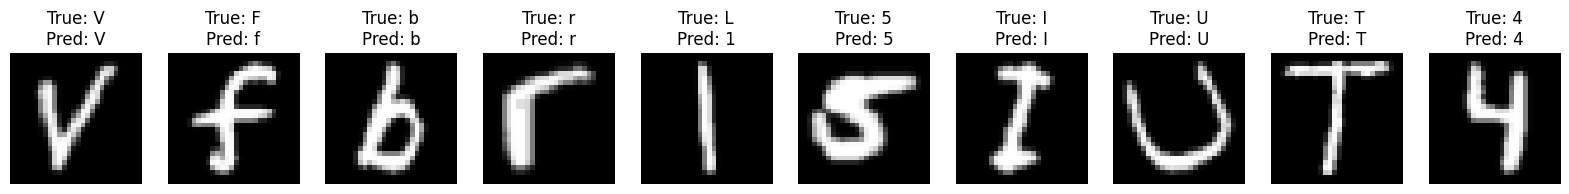

In [22]:
def predict(image):
    # Применяем преобразования к изображению, если они требуются
    # image = transform(input_image)  # Примените необходимые преобразования
    # Убедитесь, что изображение имеет форму (1, 1, H, W) для модели
    if image.dim() == 2:  # Если изображение 2D (H, W)
        image = image.unsqueeze(0)  # Добавляем размер канала
    image = image.unsqueeze(0)  # Добавляем размер батча

    #print('image shape:', image.shape)

    with torch.no_grad():  # Отключаем градиенты для повышения производительности
        output = model_cnn_3(image)  # Получаем выход модели
        _, predicted_class = torch.max(output.data, 1)  # Находим класс с максимальной вероятностью
        predicted_label = predicted_class.item()  # Получаем метку класса как целое число
        #print('predicted_label:', predicted_label)

        pred = label_dict[predicted_label]  # Получаем предсказанную метку
        #print('predicted symbol:', pred)

    return pred

# Проверяем предсказания
fig, axs = plt.subplots(1, 10, figsize=(20, 5))
for i in range(10):
    random_index = np.random.randint(0, len(train_data))
    #print('Random index:', random_index)
    image, label = train_data[random_index]

    # Преобразование изображения в NumPy массив для корректного отображения
    image_np = image.squeeze(0).numpy()  # Убираем размер канала и преобразуем в NumPy массив

    pred = predict(image)  # Предсказание для изображения

    # Отображаем изображение
    axs[i].imshow(image_np, cmap='gray')  # Используем cmap='gray' для черно-белых изображений
    # Добавляем отображение истинной метки и предсказанного значения
    axs[i].set_title(f'True: {label_dict[label]}\nPred: {pred}')
    axs[i].axis('off')

plt.show()


# Final model

In [7]:
# Используем функцию для очистки состояния
#clear_training_state(model_cnn_3, optimizer)

In [8]:
# Определение модели
class ImprovedCNNModel(nn.Module):
    def __init__(self):
        super(ImprovedCNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Убедитесь в правильном размере
        self.fc2 = nn.Linear(128, 47)  # Для 47 классов

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [9]:
# Инициализация модели и оптимизатора
model = ImprovedCNNModel()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.CrossEntropyLoss()

# Обучение модели
n_epochs = 10

for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0

    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = loss_function(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch {epoch + 1}/{n_epochs}, Loss: {running_loss / len(train_loader):.4f}')

    # Валидация модели после каждой эпохи
    model.eval()
    correct = 0

    with torch.no_grad():
        for data, target in val_loader:
            output = model(data)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()

    accuracy = correct / len(val_loader.dataset)
    print(f'Validation Accuracy: {accuracy:.4f}')

Epoch 1/10, Loss: 0.6351
Validation Accuracy: 0.8478
Epoch 2/10, Loss: 0.4068
Validation Accuracy: 0.8518
Epoch 3/10, Loss: 0.3564
Validation Accuracy: 0.8661
Epoch 4/10, Loss: 0.3216
Validation Accuracy: 0.8766
Epoch 5/10, Loss: 0.2939
Validation Accuracy: 0.8720
Epoch 6/10, Loss: 0.2736
Validation Accuracy: 0.8768
Epoch 7/10, Loss: 0.2520
Validation Accuracy: 0.8780
Epoch 8/10, Loss: 0.2351
Validation Accuracy: 0.8788
Epoch 9/10, Loss: 0.2185
Validation Accuracy: 0.8737
Epoch 10/10, Loss: 0.2035
Validation Accuracy: 0.8767


In [10]:

# Инициализация переменных для хранения результатов
class_correct = [0] * 47  # Для каждого из 47 классов
class_total = [0] * 47

# Оценка модели на тестовом наборе данных
with torch.no_grad():
    for data, target in val_loader:
        output = model(data)  # Получение предсказаний от модели
        _, predicted = torch.max(output, 1)  # Получение индексов классов с максимальным значением вероятности

        # Подсчет правильных предсказаний для каждого класса
        for i in range(len(target)):
            label = target[i].item()  # Получение метки класса
            class_correct[label] += (predicted[i] == label).item()  # Увеличение счетчика для правильного предсказания
            class_total[label] += 1  # Увеличение общего количества примеров для данного класса

# Вывод результатов по каждому классу
for i in range(47):
    if class_total[i] > 0:  # Избегаем деления на ноль
        accuracy = class_correct[i] / class_total[i]
        print(label_dict[i])
        print(f'Accuracy of class {i}: {accuracy:.2f}')
    else:
        print(f'Class {i} has no samples in the test set.')

0
Accuracy of class 0: 0.84
1
Accuracy of class 1: 0.76
2
Accuracy of class 2: 0.88
3
Accuracy of class 3: 0.97
4
Accuracy of class 4: 0.91
5
Accuracy of class 5: 0.90
6
Accuracy of class 6: 0.95
7
Accuracy of class 7: 0.98
8
Accuracy of class 8: 0.93
9
Accuracy of class 9: 0.76
A
Accuracy of class 10: 0.96
B
Accuracy of class 11: 0.96
C
Accuracy of class 12: 0.95
D
Accuracy of class 13: 0.89
E
Accuracy of class 14: 0.96
F
Accuracy of class 15: 0.87
G
Accuracy of class 16: 0.94
H
Accuracy of class 17: 0.96
I
Accuracy of class 18: 0.66
J
Accuracy of class 19: 0.95
K
Accuracy of class 20: 0.96
L
Accuracy of class 21: 0.46
M
Accuracy of class 22: 0.97
N
Accuracy of class 23: 0.98
O
Accuracy of class 24: 0.51
P
Accuracy of class 25: 0.97
Q
Accuracy of class 26: 0.94
R
Accuracy of class 27: 0.96
S
Accuracy of class 28: 0.93
T
Accuracy of class 29: 0.93
U
Accuracy of class 30: 0.93
V
Accuracy of class 31: 0.94
W
Accuracy of class 32: 0.98
X
Accuracy of class 33: 0.95
Y
Accuracy of class 34: 

In [11]:
# Сохранение модели в формате .ckpt
torch.save(model.state_dict(), 'model_rot_f.ckpt') 

In [12]:
# Вывод результатов по каждому классу с accuracy < 0.87
print("Classes with accuracy < 0.87:")
for i in range(47):
    if class_total[i] > 0:  # Избегаем деления на ноль
        accuracy = class_correct[i] / class_total[i]
        if accuracy < 0.87:  # Проверяем условие на точность
            print(label_dict[i])  # Выводим метку класса
            print(f'Accuracy of class {i}: {accuracy:.2f}')
    else:
        print(f'Class {i} has no samples in the test set.')

Classes with accuracy < 0.87:
0
Accuracy of class 0: 0.84
1
Accuracy of class 1: 0.76
9
Accuracy of class 9: 0.76
I
Accuracy of class 18: 0.66
L
Accuracy of class 21: 0.46
O
Accuracy of class 24: 0.51
f
Accuracy of class 40: 0.29
g
Accuracy of class 41: 0.68
q
Accuracy of class 44: 0.59


In [26]:
# Загрузка предварительно обученной модели
model = ImprovedCNNModel()  # модель уже определена
model.load_state_dict(torch.load('model_rot_f.ckpt'))

/tmp/ipykernel_6454/2442658450.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_rot_f.ckpt'))


<All keys matched successfully>

In [29]:
# Вывод информации о модели
summary(model, input_size=(1, 1, 28, 28))  # Указываем размер входного тензора [batch_size, channels, height, width]

[W104 14:29:23.533522689 NNPACK.cpp:61] Could not initialize NNPACK! Reason: Unsupported hardware.


Layer (type:depth-idx)                   Output Shape              Param #
ImprovedCNNModel                         [1, 47]                   --
├─Conv2d: 1-1                            [1, 32, 28, 28]           320
├─BatchNorm2d: 1-2                       [1, 32, 28, 28]           64
├─MaxPool2d: 1-3                         [1, 32, 14, 14]           --
├─Conv2d: 1-4                            [1, 64, 14, 14]           18,496
├─BatchNorm2d: 1-5                       [1, 64, 14, 14]           128
├─MaxPool2d: 1-6                         [1, 64, 7, 7]             --
├─Linear: 1-7                            [1, 128]                  401,536
├─Linear: 1-8                            [1, 47]                   6,063
Total params: 426,607
Trainable params: 426,607
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 4.28
Input size (MB): 0.00
Forward/backward pass size (MB): 0.60
Params size (MB): 1.71
Estimated Total Size (MB): 2.31

# Optuna

In [16]:
# Используем функцию для очистки состояния
clear_training_state(model, optimizer)

# Создание загрузчиков данных
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [21]:
# Определение модели
class TunedCNNModel(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(TunedCNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Убедитесь в правильном размере
        self.fc2 = nn.Linear(128, 47)  # Для 47 классов
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x



In [22]:
# Инициализация модели и оптимизатора
model = TunedCNNModel()#.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.CrossEntropyLoss()

In [23]:
# Функция для обучения и валидации модели
def objective(trial):
    # Подбор гиперпараметров
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)

    model = TunedCNNModel(dropout_rate=dropout_rate)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_function = nn.CrossEntropyLoss()

    # Обучение модели
    n_epochs = 5
    for epoch in range(n_epochs):
        model.train()
        running_loss = 0.0

        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = loss_function(output, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

    # Валидация модели
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            output = model(data)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()

    accuracy = correct / len(val_loader.dataset)

    return accuracy

In [25]:
# Запуск оптимизации гиперпараметров с помощью Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)

# Вывод лучших гиперпараметров
print("Best hyperparameters: ", study.best_params)
print("Best accuracy: ", study.best_value)

[I 2025-01-04 11:18:18,627] A new study created in memory with name: no-name-e1bb66ec-60ff-44a0-9629-f96b5d0c6b75
/tmp/ipykernel_6454/123219436.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
[I 2025-01-04 11:54:00,500] Trial 0 finished with value: 0.02127659574468085 and parameters: {'dropout_rate': 0.21792267578828473, 'lr': 0.02426779378495144}. Best is trial 0 with value: 0.02127659574468085.
[I 2025-01-04 12:22:40,954] Trial 1 finished with value: 0.825 and parameters: {'dropout_rate': 0.1874856080681782, 'lr': 1.35497681455632e-05}. Best is trial 1 with value: 0.825.
[I 2025-01-04 12:55:17,474] Trial 2 finished with value: 0.27617021276595743 and parameters: {'dropout_rate': 0.3700366081357598, 'lr': 0.07004427573568306}. Best is trial 1 with value: 0.825.
[I 2025-01-04 

Best hyperparameters:  {'dropout_rate': 0.19849537410805584, 'lr': 0.00012775760131190938}
Best accuracy:  0.8692553191489362


# Enhanced

In [36]:
class EnhancedCNNModel(nn.Module):
    def __init__(self):
        super(EnhancedCNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.dropout = nn.Dropout(0.5)  # Дропаут для регуляризации
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  
        self.fc2 = nn.Linear(128, 47)  

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Применение дропаута перед выходным слоем
        x = self.fc2(x)
        return x

In [37]:
# Используем функцию для очистки состояния
clear_training_state(model, optimizer)

# Создание загрузчиков данных
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [38]:
def train_model(model, train_loader, val_loader):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_function = nn.CrossEntropyLoss()
    
    n_epochs = 10
    for epoch in range(n_epochs):
        model.train()
        running_loss = 0.0
        
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = loss_function(output, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f'Epoch {epoch + 1}/{n_epochs}, Loss: {running_loss / len(train_loader):.4f}')

        # Валидация модели после каждой эпохи
        model.eval()
        correct = 0
        
        with torch.no_grad():
            for data, target in val_loader:
                output = model(data)
                pred = output.argmax(dim=1)
                correct += pred.eq(target).sum().item()

        accuracy = correct / len(val_loader.dataset)
        print(f'Validation Accuracy: {accuracy:.4f}')




In [39]:
# Инициализация и обучение модели
model = EnhancedCNNModel()
train_model(model, train_loader, val_loader)

Epoch 1/10, Loss: 1.2413
Validation Accuracy: 0.8215
Epoch 2/10, Loss: 0.8605
Validation Accuracy: 0.8388
Epoch 3/10, Loss: 0.7670
Validation Accuracy: 0.8452
Epoch 4/10, Loss: 0.7005
Validation Accuracy: 0.8539
Epoch 5/10, Loss: 0.6604
Validation Accuracy: 0.8551
Epoch 6/10, Loss: 0.6216
Validation Accuracy: 0.8645
Epoch 7/10, Loss: 0.5936
Validation Accuracy: 0.8680
Epoch 8/10, Loss: 0.5727
Validation Accuracy: 0.8690
Epoch 9/10, Loss: 0.5520
Validation Accuracy: 0.8689
Epoch 10/10, Loss: 0.5388
Validation Accuracy: 0.8685


In [40]:

# Инициализация переменных для хранения результатов
class_correct = [0] * 47  # Для каждого из 47 классов
class_total = [0] * 47

# Оценка модели на тестовом наборе данных
with torch.no_grad():
    for data, target in val_loader:
        output = model(data)  # Получение предсказаний от модели
        _, predicted = torch.max(output, 1)  # Получение индексов классов с максимальным значением вероятности

        # Подсчет правильных предсказаний для каждого класса
        for i in range(len(target)):
            label = target[i].item()  # Получение метки класса
            class_correct[label] += (predicted[i] == label).item()  # Увеличение счетчика для правильного предсказания
            class_total[label] += 1  # Увеличение общего количества примеров для данного класса

# Вывод результатов по каждому классу
for i in range(47):
    if class_total[i] > 0:  # Избегаем деления на ноль
        accuracy = class_correct[i] / class_total[i]
        print(label_dict[i])
        print(f'Accuracy of class {i}: {accuracy:.2f}')
    else:
        print(f'Class {i} has no samples in the test set.')

0
Accuracy of class 0: 0.26
1
Accuracy of class 1: 0.77
2
Accuracy of class 2: 0.90
3
Accuracy of class 3: 0.97
4
Accuracy of class 4: 0.89
5
Accuracy of class 5: 0.83
6
Accuracy of class 6: 0.95
7
Accuracy of class 7: 0.99
8
Accuracy of class 8: 0.95
9
Accuracy of class 9: 0.86
A
Accuracy of class 10: 0.97
B
Accuracy of class 11: 0.95
C
Accuracy of class 12: 0.95
D
Accuracy of class 13: 0.90
E
Accuracy of class 14: 0.98
F
Accuracy of class 15: 0.58
G
Accuracy of class 16: 0.96
H
Accuracy of class 17: 0.96
I
Accuracy of class 18: 0.64
J
Accuracy of class 19: 0.93
K
Accuracy of class 20: 0.96
L
Accuracy of class 21: 0.41
M
Accuracy of class 22: 0.98
N
Accuracy of class 23: 0.95
O
Accuracy of class 24: 0.89
P
Accuracy of class 25: 0.96
Q
Accuracy of class 26: 0.92
R
Accuracy of class 27: 0.97
S
Accuracy of class 28: 0.94
T
Accuracy of class 29: 0.92
U
Accuracy of class 30: 0.91
V
Accuracy of class 31: 0.94
W
Accuracy of class 32: 0.99
X
Accuracy of class 33: 0.94
Y
Accuracy of class 34: 

In [41]:
# Вывод результатов по каждому классу с accuracy < 0.87
print("Classes with accuracy < 0.87:")
for i in range(47):
    if class_total[i] > 0:  # Избегаем деления на ноль
        accuracy = class_correct[i] / class_total[i]
        if accuracy < 0.87:  # Проверяем условие на точность
            print(label_dict[i])  # Выводим метку класса
            print(f'Accuracy of class {i}: {accuracy:.2f}')
    else:
        print(f'Class {i} has no samples in the test set.')

Classes with accuracy < 0.87:
0
Accuracy of class 0: 0.26
1
Accuracy of class 1: 0.77
5
Accuracy of class 5: 0.83
9
Accuracy of class 9: 0.86
F
Accuracy of class 15: 0.58
I
Accuracy of class 18: 0.64
L
Accuracy of class 21: 0.41
f
Accuracy of class 40: 0.65
g
Accuracy of class 41: 0.54
q
Accuracy of class 44: 0.56


In [42]:
# Сохранение модели в формате .ckpt
torch.save(model.state_dict(), 'model_rot_enh.ckpt') 

In [ ]:
# Загрузка предварительно обученной модели
model = ImprovedCNNModel()  # модель уже определена
model.load_state_dict(torch.load('model_rot_enh.ckpt'))

In [43]:
# Вывод информации о модели
summary(model, input_size=(1, 1, 28, 28))  # Указываем размер входного тензора [batch_size, channels, height, width]

Layer (type:depth-idx)                   Output Shape              Param #
EnhancedCNNModel                         [1, 47]                   --
├─Conv2d: 1-1                            [1, 32, 28, 28]           320
├─BatchNorm2d: 1-2                       [1, 32, 28, 28]           64
├─MaxPool2d: 1-3                         [1, 32, 14, 14]           --
├─Conv2d: 1-4                            [1, 64, 14, 14]           18,496
├─BatchNorm2d: 1-5                       [1, 64, 14, 14]           128
├─MaxPool2d: 1-6                         [1, 64, 7, 7]             --
├─Linear: 1-7                            [1, 128]                  401,536
├─Dropout: 1-8                           [1, 128]                  --
├─Linear: 1-9                            [1, 47]                   6,063
Total params: 426,607
Trainable params: 426,607
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 4.28
Input size (MB): 0.00
Forward/backward pass size (MB): 0.60
Params size (MB): 1.71
Estimated Total 